# Convolutional Neural Networks

Realizaremos un ejercicio descrito en el blog www.aprendemachinelearning.com para hacer reconocimiento de imágenes.

# Importar Librerías

In [3]:
from skimage.transform import resize
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
#import keras
#from keras.utils import to_categorical
#from keras.models import Sequential,Input,Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU


# Ejecutar solo en entorno local

In [5]:
dirImages = "sportimages"
imageTest = "test/golf.jpg"

# Ejecutar solo en Google Colab

In [ ]:
! git clone -b EX-CNN https://github.com/thonyguev/machine-learning.git
dirImages = "machine-learning/sportimages"
imageTest = "machine-learning/test/golf.jpg"

# Cargar set de Imágenes

In [6]:
dirname = os.path.join(os.getcwd(), dirImages)
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /home/sportimages/
/home/sportimages/sportimages/f1 1
/home/sportimages/sportimages/futbol 5053
/home/sportimages/sportimages/boxeo 7617
/home/sportimages/sportimages/ciclismo 7125
/home/sportimages/sportimages/natacion 7533
/home/sportimages/sportimages/americano 5172
/home/sportimages/sportimages/basket 9348
/home/sportimages/sportimages/golf 8823
/home/sportimages/sportimages/beisball 9768
/home/sportimages/sportimages/tenis 7752
Directorios leidos: 10
Imagenes en cada directorio [5054, 7617, 7125, 7533, 5172, 9348, 8823, 9768, 7752, 8936]
suma Total de imagenes en subdirs: 77128


# Creamos las etiquetas

In [7]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  77128


In [8]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 f1
1 futbol
2 boxeo
3 ciclismo
4 natacion
5 americano
6 basket
7 golf
8 beisball
9 tenis


In [9]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


# Creamos Sets de Entrenamiento y Test

In [10]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)


Text(0.5, 1.0, 'Ground Truth : 4')

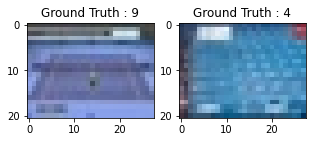

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

In [12]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [13]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Creamos el Set de Entrenamiento y Validación

In [14]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [15]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


# Creamos el modelo de CNN

In [16]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 6 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [17]:
sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation='softmax'))

2022-07-09 22:16:35.005607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-09 22:16:35.005689: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-09 22:16:35.005708: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ef5a8635388a): /proc/driver/nvidia/version does not exist
2022-07-09 22:16:35.006037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
sport_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4928)              0         
                                                                 
 dense (Dense)               (None, 32)                157728    
                                                        

In [19]:
sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [20]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/6


2022-07-09 22:16:45.266515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 348291216 exceeds 10% of free system memory.


770/772 [============================>.] - ETA: 0s - loss: 2.1223 - accuracy: 0.2313

2022-07-09 22:16:55.562896: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 87078096 exceeds 10% of free system memory.


772/772 [==============================] - 11s 14ms/step - loss: 2.1220 - accuracy: 0.2315 - val_loss: 1.8039 - val_accuracy: 0.5413
Epoch 2/6
772/772 [==============================] - 11s 14ms/step - loss: 1.7854 - accuracy: 0.3916 - val_loss: 1.4701 - val_accuracy: 0.6612
Epoch 3/6
772/772 [==============================] - 10s 13ms/step - loss: 1.5827 - accuracy: 0.4697 - val_loss: 1.2787 - val_accuracy: 0.6895
Epoch 4/6
772/772 [==============================] - 9s 12ms/step - loss: 1.4466 - accuracy: 0.5164 - val_loss: 1.1437 - val_accuracy: 0.7089
Epoch 5/6
772/772 [==============================] - 9s 12ms/step - loss: 1.3492 - accuracy: 0.5486 - val_loss: 1.0509 - val_accuracy: 0.7426
Epoch 6/6
772/772 [==============================] - 9s 11ms/step - loss: 1.2760 - accuracy: 0.5760 - val_loss: 0.9818 - val_accuracy: 0.7554


In [21]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

INFO:tensorflow:Assets written to: sports_mnist.h5py/assets


INFO:tensorflow:Assets written to: sports_mnist.h5py/assets


# Evaluamos la red

In [22]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

 31/483 [>.............................] - ETA: 1s - loss: 1.0151 - accuracy: 0.7480

2022-07-09 22:19:27.881969: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 108845856 exceeds 10% of free system memory.


483/483 [==============================] - 2s 3ms/step - loss: 0.9946 - accuracy: 0.7493


In [23]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9946393370628357
Test accuracy: 0.749319314956665


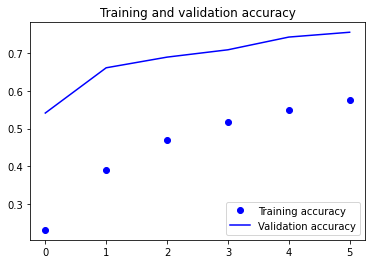

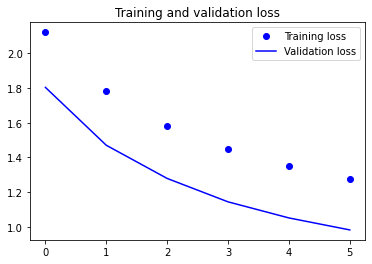

In [24]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes2 = sport_model.predict(test_X)

 18/483 [>.............................] - ETA: 1s 

2022-07-09 22:19:45.656073: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 108845856 exceeds 10% of free system memory.


483/483 [==============================] - 2s 3ms/step


In [26]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [27]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

# Aprendamos de los errores: Qué mejorar

Found 11559 correct labels


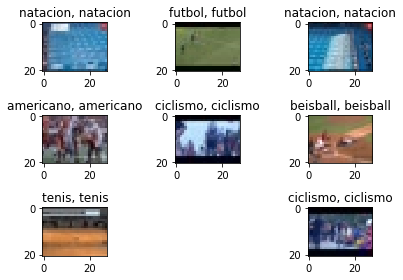

In [28]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 3867 incorrect labels


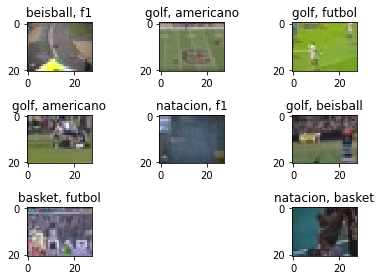

In [29]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [30]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.78      0.20      0.31       982
     Class 1       0.90      0.70      0.79      1552
     Class 2       0.75      0.89      0.82      1434
     Class 3       0.92      0.99      0.95      1510
     Class 4       0.88      0.92      0.90      1016
     Class 5       0.51      0.36      0.42      1875
     Class 6       0.79      0.81      0.80      1769
     Class 7       0.52      0.86      0.65      1866
     Class 8       0.79      0.66      0.72      1625
     Class 9       0.90      1.00      0.95      1797

    accuracy                           0.75     15426
   macro avg       0.77      0.74      0.73     15426
weighted avg       0.76      0.75      0.73     15426



# Prediccion de una nueva imagen

1/1 [==============================] - 0s 16ms/step


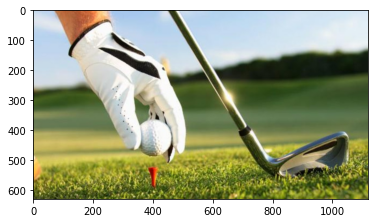

test/golf.jpg golf


In [31]:
images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = [imageTest]

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    image = img.imread(imageTest)
    plt.imshow(image)
    plt.show()
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])